In [1]:
# ----------------- Importing Libraries ----------------- 

import pandas as pd
import json
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
import re
import tensorflow_text as tf_text

2024-04-25 10:13:58.292998: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 10:13:58.293100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 10:13:58.424042: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# ---------------  Extraction des données ---------------

csv = pd.read_csv("/kaggle/input/hack-train/hack_train.csv")
csvFull = csv.rename(columns={'text': 'answers', "label" : "is_human"})
answers_df = csvFull.drop(columns="src")
# Checking the len
answers_df = answers_df.explode('answers', ignore_index=True)
answers_df = answers_df.dropna(subset=['answers'], ignore_index=True)

,answers,is_human
0,Little disclaimer: this deals with US laws and...,1
1,"Read: Mentally Retarded Downs. See, we've got ...",1
2,"If any of you frequent rbadhistory, there is a...",1
3,"I believe in a flat tax system, where everyone...",1
4,"Edit: Ok guy's, my views have been changed on ...",1
...,...,...
56814,We consider the recovery of a source term f (x...,1
56815,"Self-supervised learning (SlfSL), aiming at le...",1
56816,Recurrent neural networks (RNNs) have achieved...,1
56817,Deep reinforcement learning (DRL) is a booming...,1


In [4]:
# ---------------  Vectorisation des données ---------------

max_features = 75000
embedding_dim = 64
sequence_length = 512*2
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    ngrams = (3,5),
    output_mode="int",
    output_sequence_length=sequence_length,
    pad_to_max_tokens=True
)
vectorize_layer.adapt(answers_df['answers'])
X = vectorize_layer(answers_df['answers']).numpy()

In [6]:
# ---------------------- Splitting the data ----------------------

y = answers_df['is_human']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (45455, 1024)
X_test shape is  (11364, 1024)
y_train shape is  (45455,)
y_test shape is  (11364,)


In [7]:
# ---------------------- Model ----------------------

from tensorflow.keras import Model, Input, layers
from tensorflow.keras.layers import TextVectorization, Embedding, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D, Dense, Dropout

import tensorflow as tf

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    def get_config(self):
        config = super().get_config()
        config["att"] = self.att
        config["ffn"] = self.ffn
        config["layernorm1"] = self.layernorm1
        config["layernorm2"] = self.layernorm2
        config["dropout1"] = self.dropout1
        config["dropout2"] = self.dropout2
        return config

inputs = Input(shape=(sequence_length,), dtype="int64")
x = Embedding(max_features, embedding_dim)(inputs)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
transformer_block = TransformerBlock(embedding_dim, 2, 32)
x = transformer_block(x, training=True)
x = Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid", name="predictions")(x)

model = Model(inputs=inputs, outputs=predictions)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 1024, 64)       │     4,800,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1024, 64)       │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 1024, 64)       │        37,664 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 340, 128)       │        57,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,936,609 (18.83 MB)

 Trainable params: 4,936,609 (18.83 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# ---------------------- Training ----------------------

from keras.callbacks import EarlyStopping,ModelCheckpoint

checkpoint_cb =ModelCheckpoint("model.keras", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=3, restore_best_weights=True)
model.compile(optimizer ='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train,y_train, epochs=5, validation_split=.1, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/5
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 150s 110ms/step - accuracy: 0.9044 - loss: 0.3029 - val_accuracy: 0.9285 - val_loss: 0.2211
Epoch 2/5
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 140s 109ms/step - accuracy: 0.9483 - loss: 0.1845 - val_accuracy: 0.9254 - val_loss: 0.2266
Epoch 3/5
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 140s 110ms/step - accuracy: 0.9629 - loss: 0.1372 - val_accuracy: 0.9276 - val_loss: 0.2362
Epoch 4/5
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 140s 110ms/step - accuracy: 0.9720 - loss: 0.1115 - val_accuracy: 0.9309 - val_loss: 0.3080


In [10]:
# ---------------------- Evaluation ----------------------

score, acc= model.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

356/356 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.9330 - loss: 0.2166
Test Loss = 0.2209395468235016
Test Accuracy = 0.9321541786193848


In [11]:
# ---------------------- Prediction ----------------------

import numpy as np 
predictions = model.predict(X_test)
y_pred = np.where(predictions>=.5,1,0)
y_test_1d = np.ravel(y_test)
y_pred_1d = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test_1d, 'Prediction': y_pred_1d})
df

356/356 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step


,Actual,Prediction
0,0,0
1,1,1
2,0,0
3,1,1
4,1,1
...,...,...
11359,0,0
11360,0,0
11361,0,0
11362,0,0


array([[5012,  540],
       [ 231, 5581]])

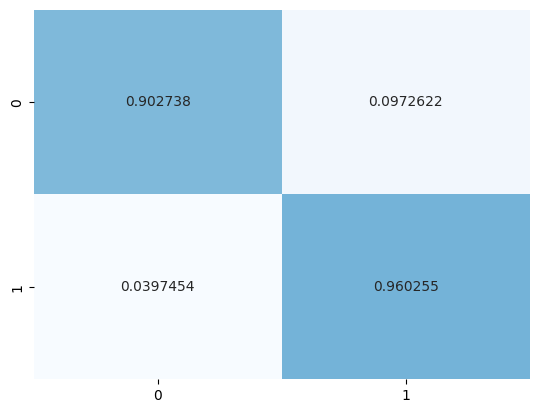

In [12]:
# ---------------------- Confusion Matrix ----------------------

import seaborn as sns
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_test_1d,y_pred_1d)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [13]:
# ---------------------- Classification Report ----------------------

from sklearn.metrics import classification_report
ClassificationReport = classification_report(y_test_1d,y_pred_1d)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.96      0.90      0.93      5552
           1       0.91      0.96      0.94      5812

    accuracy                           0.93     11364
   macro avg       0.93      0.93      0.93     11364
weighted avg       0.93      0.93      0.93     11364



In [14]:
# ---------------------- Save the model ----------------------

model.save_weights('../model/my_model.weights.h5')